In [1]:
from __future__ import division, print_function
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
train_df = pd.read_csv('train_sessions.csv', index_col='session_id')
test_df = pd.read_csv('test_sessions.csv', index_col='session_id')
times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)
train_df = train_df.sort_values(by='time1')
print(train_df.shape)
print(test_df.shape)
train_df.head()

(253561, 21)
(82797, 20)


,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


In [2]:
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')
with open(r"site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)
sites_dict = pd.DataFrame(list(site_dict.keys()),
                        index=list(site_dict.values()),
                        columns=['site'])
print(u'Всего сайтов: ', sites_dict.shape[0])
sites_dict.head()

Всего сайтов:  48371


,site
25075,www.abmecatronique.com
13997,groups.live.com
42436,majeureliguefootball.wordpress.com
30911,cdt46.media.tourinsoft.eu
8104,www.hdwallpapers.eu


In [3]:
top_sites = pd.Series(train_df[sites].fillna(0).values.flatten()
                     ).value_counts().sort_values(ascending=False).head(5)
print(top_sites)
sites_dict.iloc[top_sites.index]

21     123776
0      122730
23      87619
782     77055
22      58258
Name: count, dtype: int64


,site
5671,www.pacajob.com
25075,www.abmecatronique.com
7104,cbv.sfr.bench.cedexis.com
39605,cid-d6bf976dfdf5d212.users.storage.live.com
32074,mathaa.epfl.ch


In [4]:
time_df = pd.DataFrame(index=train_df.index)
time_df['target']=train_df['target']
time_df['min'] = train_df[times].min(axis=1)
time_df['min'] = pd.to_datetime(time_df['min'])
time_df['max'] = train_df[times].min(axis=1)
time_df['max'] = pd.to_datetime(time_df['max'])
time_df['seconds'] = (time_df['max'].values - time_df['min'].values) / np.timedelta64(1, 's')
time_df.head()

,target,min,max,seconds
session_id,,,,
21669,0,2013-01-12 08:05:57,2013-01-12 08:05:57,0.0
54843,0,2013-01-12 08:37:23,2013-01-12 08:37:23,0.0
77292,0,2013-01-12 08:50:13,2013-01-12 08:50:13,0.0
114021,0,2013-01-12 08:50:17,2013-01-12 08:50:17,0.0
146670,0,2013-01-12 08:50:20,2013-01-12 08:50:20,0.0


In [5]:
y_train = train_df['target']
full_df = pd.concat([train_df.drop('target',  axis=1), test_df])
iloc_split = train_df.shape[0]
print('y_train', y_train.shape)
print('train_df', train_df.shape)
print('full_df', full_df.shape)

y_train (253561,)
train_df (253561, 21)
full_df (336358, 20)


In [6]:
full_sites = full_df[sites]
full_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947


In [7]:
sites_flatten = full_sites.values.flatten()
full_sites_sparse = csr_matrix(([1]*sites_flatten.shape[0],
                               sites_flatten,
                               range(0, sites_flatten.shape[0] + 10,
                                    10)))[:, 1:]
print('sites_flatten', sites_flatten.shape)
print('full_sites_sparse', full_sites_sparse.shape)
print('Calculation Memory Size: ', full_sites_sparse.shape[0]*full_sites_sparse.shape[0]*4)

sites_flatten (3363580,)
full_sites_sparse (336358, 48371)
Calculation Memory Size:  452546816656


In [8]:
print('{0} elements * {1} bytes = {2} bytes'.format(
    full_sites_sparse.count_nonzero(),
    4, full_sites_sparse.count_nonzero() * 4))
print('Real Memory Size = {0} bytes'.format(full_sites_sparse.data.nbytes))

1866898 elements * 4 bytes = 7467592 bytes
Real Memory Size = 7467592 bytes


In [9]:
def get_auc_lr_valid(x, y, C=1.0, seed=17, ratio = 0.9):
    iloc = int(round(x.shape[0] * ratio))
    lr = LogisticRegression(C=C,
                           random_state=seed,
                           n_jobs=-1).fit(x[:iloc, :], y[:iloc])
    y_pred=lr.predict_proba(x[iloc:, :])[:, 1]
    score = roc_auc_score(y[iloc:], y_pred)
    return score

In [10]:
%%time
x_train = full_sites_sparse[:iloc_split, :]
print(get_auc_lr_valid(x_train, y_train))

0.9199789471713791
CPU times: total: 125 ms
Wall time: 7.16 s


In [11]:
def write_to_submission_file(predicted_labels, out_file,
                            target='target', index_label='session_id'):
    predicted_df=pd.DataFrame(predicted_labels,
                             index=np.arange(1, predicted_labels.shape[0]+1),
                             columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [12]:
%%time
lr = LogisticRegression(C=1.0, random_state=17).fit(x_train, y_train)
x_test = full_sites_sparse[:iloc_split, :]
y_test = lr.predict_proba(x_test)[:, 1]
write_to_submission_file(y_test, 'baseline_sites.csv')

C:\ProgramData\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


CPU times: total: 5.95 s
Wall time: 4.25 s


In [13]:
full_new_feat = pd.DataFrame(index=full_df.index)
full_new_feat['start_month']=full_df['time1'].apply(lambda ts: 100* ts.year + ts.month)
full_new_feat.head()

,start_month
session_id,
21669,201301
54843,201301
77292,201301
114021,201301
146670,201301


In [14]:
print('full_new_feat.shape', full_new_feat.shape)
tmp = full_new_feat[['start_month']].to_numpy()
print('tmp.shape', tmp.shape)
print('full_sites_sparse.shape', full_sites_sparse.shape)
x_train = csr_matrix(hstack([full_sites_sparse[:iloc_split,:], tmp[:iloc_split, :]]))
print(get_auc_lr_valid(x_train, y_train))

full_new_feat.shape (336358, 1)
tmp.shape (336358, 1)
full_sites_sparse.shape (336358, 48371)
0.8442074831287529


In [15]:
tmp = StandardScaler().fit_transform(full_new_feat[['start_month']])
x_train = csr_matrix(hstack([full_sites_sparse[:iloc_split,:], tmp[:iloc_split,:]]))
print(get_auc_lr_valid(x_train, y_train))

0.9199655117651889


In [22]:
full_new_feat['n_unique_sites'] = (full_sites.to_numpy()>0).sum(1)
tmp = StandardScaler().fit_transform(full_new_feat[['start_month', 'n_unique_sites']])
x_train = csr_matrix(hstack([full_sites_sparse[:iloc_split,:], tmp[:iloc_split,:]]))
print('x_train.shape', x_train.shape)
print(get_auc_lr_valid(x_train,y_train))

x_train.shape (253561, 48373)
0.9154347606867335


In [24]:
full_new_feat['start_hour'] = time_df['min'].dt.hour
full_new_feat['morning'] = (full_new_feat['start_hour'] <= 11).astype(np.int32)
full_new_feat

,start_month,n_unique_sites,start_hour,morning
session_id,,,,
21669,201301,2,8,1
54843,201301,4,8,1
77292,201301,10,8,1
114021,201301,10,8,1
146670,201301,10,8,1
...,...,...,...,...
82793,201410,3,8,1
82794,201405,10,8,1
82795,201405,10,13,0


In [26]:
%%time
tmp_scaled = StandardScaler().fit_transform(full_new_feat[['start_month', 'start_hour',
                                                         'morning']])
x_train = csr_matrix(hstack([full_sites_sparse[:iloc_split,:],
                            tmp_scaled[:iloc_split,:]]))
score_C_1 = get_auc_lr_valid(x_train, y_train)
print(score_C_1)

0.9589330204242328
CPU times: total: 78.1 ms
Wall time: 3.85 s


In [27]:
%%time
Cs = np.logspace(-3, 1, 10)
scores = []
for C in Cs:
    sc = get_auc_lr_valid(x_train,y_train,C=C)
    scores.append(sc)
    print(C, ' - > ', sc)

0.001  - >  0.9351051011067151
0.0027825594022071257  - >  0.9430425579322639
0.007742636826811269  - >  0.9509542006627731
0.021544346900318832  - >  0.9570750094198803
0.05994842503189409  - >  0.9601791920882667
0.1668100537200059  - >  0.9607247601553556
0.46415888336127775  - >  0.9597945469762184
1.2915496650148828  - >  0.9585453561197822
3.593813663804626  - >  0.9567601076523242
10.0  - >  0.9545761748281475
CPU times: total: 297 ms
Wall time: 26.2 s


In [28]:
np.max(scores)

0.9607247601553556

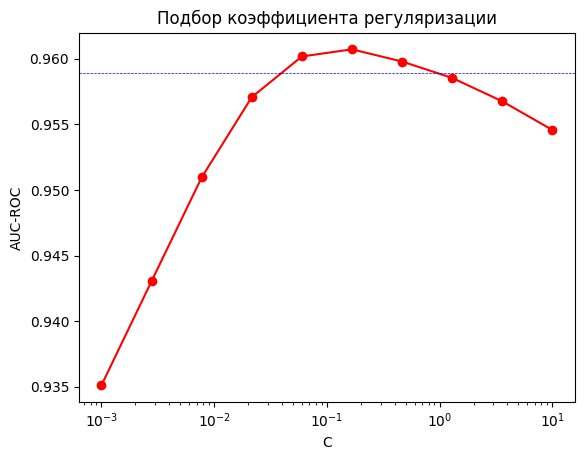

In [30]:
plt.plot(Cs, scores, 'ro-')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('AUC-ROC')
plt.title('Подбор коэффициента регуляризации')
plt.axhline(y=score_C_1, linewidth=.5, color='b', linestyle='dashed')
plt.show()

In [31]:
score_result = get_auc_lr_valid(x_train, y_train, C=0.1668101)
print(score_result)

0.960726571670797


In [33]:
tmp_scaled = StandardScaler().fit_transform(
    full_new_feat[['start_month', 'start_hour', 'morning']])
x_train = csr_matrix(hstack([full_sites_sparse[:iloc_split,:],
                            tmp_scaled[:iloc_split,:]]))
x_test = csr_matrix(hstack([full_sites_sparse[:iloc_split,:],
                           tmp_scaled[:iloc_split,:]]))
lr = LogisticRegression(C=C, random_state=17).fit(x_train,y_train)
y_test = lr.predict_proba(x_test)[:, 1]
write_to_submission_file(y_test, 'baseline_res.csv')

C:\ProgramData\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
